##### **Welcome to Exploring Neural Networks for Digit Recognition**

In this notebook, we delve into the intricate details of building a neural network from scratch for digit recognition using NumPy and Python. Our main focus is on understanding the intricacies of the Adam Optimizer alongside Mini-Batch Gradient Descent.

##### **Objectives and Goals**

The primary objectives of this exploration are twofold:

1. Detailed Analysis: Provide an in-depth analysis of designing and implementing a neural network, including training processes and optimization techniques.

2. Optimization Techniques: Explore and explain the theory behind Mini-Batch Gradient Descent and the advanced Adam Optimizer for model optimization.

This notebook serves as part 2 of our from-scratch series. If you're interested in the basics using Vanilla Gradient Descent, you can find our previous work [here](https://github.com/Kiana-Jafari/Digit-Recognition-From-Scratch).

### Task 1a. Imports and loading

We begin by importing essential libraries and loading a subset of the MNIST dataset from Google Colaboratory.

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load and Read the Training data
data = pd.read_csv('/content/sample_data/mnist_train_small.csv')
data = data.rename(columns={'6':'label'})

# Display a few couple of rows
data.head()

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Task 2a. Data Preprocessing

In this task, the dataset is preprocessed, scaled (Normalize the pixel values to a range of [0, 1]), transposed, and split into features (input) and labels (output) for further analysis.


In [3]:
# Convert the data into NumPy array
data = np.array(data)

# Transpose the data
data = data.T

# Display the data
data[:5]

array([[5, 7, 9, ..., 2, 9, 5],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
# Extract the target from the whole dataset
label = data[0]

# Produce a 2x2 One-Hot Encoded matrix
number_classes = len(np.unique(data[0]))
target = np.eye(number_classes)[label]

# Transpose the target and display it
target = target.T

target[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
# Preprocess the features set
features = data[1:]

# Scale by the Maximum Factor
features = features / 255.0

# Display the features
features[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# Print the shape of both sets
print(f"Shape of Features: {features.shape}")
print(f"Shape of Target: {target.shape}")

Shape of Features: (784, 19999)
Shape of Target: (10, 19999)


### Task 3a. Split data into training, and validation sets

#### Mini-Batch Gradient descent

The process of how to create mini-batches from a training set (X, Y), involves two steps:

1. *Shuffle*: Shuffle the training set (X, Y) randomly so that each column of X and Y represents a different training example. This step ensures that the examples will be split randomly into different mini-batches.

2. *Partition*: Partition the shuffled (X, Y) into mini-batches of size mini_batch_size, which is typically set to 32. Note that the number of training examples may not always be divisible by mini_batch_size, and the last mini-batch might be smaller. However, when the final mini-batch is smaller than the full mini_batch_size, it will still be used for training.

It's important to note that the last mini-batch might end up being smaller than mini_batch_size=32. If the total number of examples is not a multiple of mini_batch_size=32, then there will be m/mini_batch_size mini-batches with a full 32 examples.

In [7]:
def random_mini_batches(X, Y, validation_split=0.2, mini_batch_size=32, seed=0):

    np.random.seed(seed)  # Set seed for reproducibility
    m = X.shape[1]  # Total number of examples
    m_val = int(m * validation_split)  # Number of validation examples

    # Shuffle indices
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Split into training and validation sets
    X_train = shuffled_X[:, m_val:]
    Y_train = shuffled_Y[:, m_val:]
    X_val = shuffled_X[:, :m_val]
    Y_val = shuffled_Y[:, :m_val]

    # Generate random mini-batches for training data
    num_complete_minibatches_train = X_train.shape[1] // mini_batch_size
    mini_batches_train = []

    for k in range(num_complete_minibatches_train):
        mini_batch_X_train = X_train[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y_train = Y_train[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batches_train.append((mini_batch_X_train, mini_batch_Y_train))

    # Handling the end case (last mini-batch < mini_batch_size) for training
    if X_train.shape[1] % mini_batch_size != 0:
        mini_batch_X_train = X_train[:, num_complete_minibatches_train * mini_batch_size :]
        mini_batch_Y_train = Y_train[:, num_complete_minibatches_train * mini_batch_size :]
        mini_batches_train.append((mini_batch_X_train, mini_batch_Y_train))

    # Generate random mini-batches for validation data
    num_complete_minibatches_val = X_val.shape[1] // mini_batch_size
    mini_batches_val = []

    for k in range(num_complete_minibatches_val):
        mini_batch_X_val = X_val[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y_val = Y_val[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batches_val.append((mini_batch_X_val, mini_batch_Y_val))

    # Handling the end case (last mini-batch < mini_batch_size) for validation
    if X_val.shape[1] % mini_batch_size != 0:
        mini_batch_X_val = X_val[:, num_complete_minibatches_val * mini_batch_size :]
        mini_batch_Y_val = Y_val[:, num_complete_minibatches_val * mini_batch_size :]
        mini_batches_val.append((mini_batch_X_val, mini_batch_Y_val))

    return mini_batches_train, mini_batches_val

mini_batches_train, mini_batches_val = random_mini_batches(features, target, validation_split=0.2, mini_batch_size=32, seed=0)

print(f"Shape of train batches: {len(mini_batches_train)}")
print(f"Shape of validation batches: {len(mini_batches_val)}")

Shape of train batches: 500
Shape of validation batches: 125


It is worth noting that the training and validation batches that are returned, are a list of tuples that include x_train, y_train, x_validation, and y_validation.

### Task 1b. Activation Functions

We implement Leaky ReLU as our chosen activation function, leveraging its benefits in handling vanishing gradients.

The function's formula is defined as: ${Leaky}$ ${ReLU}$ = \begin{cases}x, & \text{if } x \geq 0 \\\alpha x, & \text{if } x < 0 \end{cases}

From Calculus we know, that the derivative of this function is given by: ${Leaky}$ ${ReLU}$ ${Derivative}$ = \begin{cases} 1, & \text{if } x \geq 0 \\ \alpha, & \text{if } x < 0 \end{cases}


In this case, $\alpha$ is considered as a small constant (say 0.01), which helps Leaky ReLU substitutes zero values with some small value

Lastly, The softmax function for the output layer is defined as:
${Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$

In [8]:
def Leaky_ReLU(z, alpha=0.01):
  return np.maximum(z, z * alpha)

def Leaky_ReLU_derivative(z, alpha=0.01):
  return np.where(z > 0, 1, alpha)

def Softmax(z):
  exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
  return exp_z / np.sum(exp_z, axis=0, keepdims=True)

### Task 2b. Feed Forward Neural Network

In [9]:
# Initializing Parameters

def initialize_parameters(input_size, hidden_size, output_size):

  np.random.seed(0) # Set seed() parameter to ensure reproducibility of results

  # Initialize the parameters
  W1 = np.random.randn(hidden_size, input_size) * 0.01 # Multiply by a small constant
  b1 = np.zeros((hidden_size, 1))
  W2 = np.random.randn(output_size, hidden_size) * 0.01
  b2 = np.zeros((output_size, 1))

  parameters = {'W1':W1,
                'b1':b1,
                'W2':W2,
                'b2':b2}

  return parameters

### Task 3b. Forward Propagation

The formulas for the Feed-Forward propagation are given as follows:

$ z_1 = W_1 * x + b_1 $

$ a_1 = f( z_1 ) $  

$ z_2 = W2 * a_1 + b_2 $

$ a_2 = Softmax( z_2 ) $

In [10]:
# Forward Propagation

def forward_propagation(x, parameters):

  # Extract the associated parameters
  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']

  z1 = np.dot(W1, x) + b1
  a1 = Leaky_ReLU(z1)
  z2 = np.dot(W2, a1) + b2
  a2 = Softmax(z2)

  forward_cache = {'z1':z1,
                   'a1':a1,
                   'z2':z2,
                   'a2':a2}

  return a2, forward_cache

### Task 4b. Cost Function
The formula for calculating the Categorical Cross Entropy is given by:

$Cost = - \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{n}[ y_k*log(a_k) ]$

In [11]:
# Calculating Cost

def compute_cost(a2, y, epsilon=1e-8):

  logprobs = -np.log(a2 + epsilon) * y # Loss for each observation
  cost = np.mean(logprobs)

  return cost

### Task 1c. Backpropagation

Backpropagation Formulas are given as follows:

$dZ_2 = ( a_2 - y )$

$ dW_2 = \frac{1}{m}. dZ_2 . a_1^T$

$ db_2 = \frac{1}{m}.sum(dZ_2, 1)$

$dZ_1 = W_2^T . dZ_2 * f_1^/(z_1) $

$dW_1 = \frac{1}{m}.dZ_1.x^T$

$db_1 = \frac{1}{m}.sum(dZ_1, 1)$

In [12]:
# Backward Propagation
def backward_propagation(x, y, forward_cache, parameters):

  W2 = parameters['W2']

  z1 = forward_cache['z1']
  a1 = forward_cache['a1']
  a2 = forward_cache['a2']

  m = x.shape[1] # Shape of the X train
  dZ2 = a2 - y
  dW2 = (1 / m) * np.dot(dZ2, a1.T)
  db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
  dZ1 = np.dot(W2.T, dZ2) * Leaky_ReLU_derivative(z1)
  dW1 = (1 / m) * np.dot(dZ1, x.T)
  db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

  gradients = {'dW1':dW1,
               'db1':db1,
               'dW2':dW2,
               'db2':db2}

  return gradients

### Task 2c. Initializing Momentum and RMSprop

#### Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. Formally, this will be the exponentially weighted average of the gradient in the previous steps.

#### RMSprop

RMSprop (Root Mean Square Propagation) is an optimization algorithm used for training neural networks. The algorithm adapts the learning rate of each parameter by scaling it with a moving average of the magnitude of recent gradients for that parameter. The gist of RMSprop is to:
1. Maintain a moving (discounted) average of the square of gradients.
2. Divide the gradient by the root of this average.

Since the main objective of RMSprop is restricting the oscillations in the vertical direction, it takes larger steps in the horizontal direction, leading to faster converging compared to the SGD+Momentum

We will implement two Python dictionaries containing the exponentially weighted average of the first and squared gradients. The associated values will be NumPy arrays of zeros with the same shape as the corresponding parameters.

In [13]:
def initialize_adam(parameters):

  # Define two empty dictionaries for `Momentum`, and `RMSprop`, respectively
  velocity = {}
  cache = {}

  for key, value in parameters.items():

    # Add the zeros to both dictionaries for each parameter (W, b)
    velocity[key] = np.zeros_like(value)
    cache[key] = np.zeros_like(value)

  return velocity, cache

For implementing the parameters update with momentum, and RMSprop, the update rules are given as follows:

#### Update Rule For Momentum:

$\left\{
\begin{align*}
v_{dW^{[l]}} &= \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} &= W^{[l]} - \alpha v_{dW^{[l]}}
\end{align*}
\right.$

</br>

$\left\{
\begin{align*}
v_{db^{[l]}} &= \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} &= b^{[l]} - \alpha v_{db^{[l]}}
\end{align*}
\right.$

#### Similarly for RMSprop:

$
\left\{
\begin{align*}
s_{dW^{[l]}} &= \beta s_{dW^{[l]}} + (1 - \beta) {dW^{[l]}}^2 \\
W^{[l]} &= W^{[l]} - \alpha \frac{dW^{[l]}}{\sqrt{s_{dW^{[l]}}} + \epsilon}
\end{align*}
\right.
$

</br>

$
\left\{
\begin{align*}
s_{db^{[l]}} &= \beta s_{db^{[l]}} + (1 - \beta) {db^{[l]}}^2 \\
b^{[l]} &= b^{[l]} - \alpha \frac{db^{[l]}}{\sqrt{s_{db^{[l]}}} + \epsilon}
\end{align*}
\right.
$

**Note** that The larger the momentum ${\beta}$ is, the smoother the update because the more we take the past gradients into account. But if ${\beta}$ is too big, it could also smooth out the updates too much.

> The default value for ${\beta_1}$ (Momentum parameter) is usually considered as 0.9

> While the value of ${\beta_2}$ (RMSprop parameter) is often considered as 0.999

### Task 3c. Updating parameters with Adam

Adam is considered one of the most effective and capable optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum to improve performance.

To do this:
1. it calculates an exponentially weighted average of past gradients and stores it in two variables: $velocity$ (before bias correction) and $velocity^ {corrected}$ (with bias correction).
2. Similarly, it calculates an exponentially weighted average of the squares of past gradients and stores them in two other variables: $cache$ (before bias correction) and $cache^ {corrected}$ (with bias correction).

3. After this, it updates parameters in a direction based on combining information from the velocity and cache variables.

$
\left\{
\begin{align*}
v_{dW^{[l]}} &= \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial J}{\partial W^{[l]}} \\
v_{dW^{[l]}}^{corrected} &= \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} &= \beta_2 s_{dW^{[l]}} + (1 - \beta_2) \left( \frac{\partial J}{\partial W^{[l]}} \right)^2 \\
s_{dW^{[l]}}^{corrected} &= \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} &= W^{[l]} - \alpha \frac{v_{dW^{[l]}}^{corrected}}{\sqrt{s_{dW^{[l]}}^{corrected}} + \epsilon} \\
b^{[l]} & = b^{[l]} - \alpha \frac{v_{db^{[l]}}^{corrected}}{\sqrt{s_{db^{[l]}}^{corrected}} + \epsilon}
\end{align*}
\right.
$

where:

- `t` counts the number of steps taken of Adam
- `L` is the number of layers
- ${\beta_1}$ and ${\beta_2}$ are hyperparameters that control the two exponentially weighted averages. (Common values 0.9 and 0.999, respectively)
- ${\alpha}$ is the learning rate. (a hyperparameter that must be tuned)
- ${\epsilon}$ is a very small number to avoid dividing by zero. (Common value: ${10^{-8}}$)

#### Learning Rate Decay

Another commonly used technique alongside Adam Optimizer and Mini-Batch Gradient Descent, is *Learning Rate Decay*. This involves gradually reducing the learning rate at each step of the process. By decrementing the learning rate over time, we can improve the convergence and overall performance of our model. As we approach the minimum, the value of the learning rate will decrease accordingly. The primary goal of learning rate decay is to fine-tune the learning process and prevent overshooting of the minima, according to the given formula:

$
\alpha = \alpha_0 \times \frac{1}{1 + \text{decay_rate} \times \text{epoch}}
\
$

In [14]:
# Update Parameters using Adam

def update_parameters(parameters, gradients, velocity, cache, learning_rate, decay_rate, current_iteration, momentum_coefficient=0.9, rmsprop_coefficient=0.999, epsilon=1e-8):

  # Rename the Beta parameters
  beta1 = momentum_coefficient
  beta2 = rmsprop_coefficient

  # Create empty dictionary for Bias Correction
  corrected_velocity = {}
  corrected_cache = {}

  # Compute decayed learning rate
  learning_rate_decay = learning_rate / (1 + decay_rate * current_iteration)

  for parameter in parameters:

    # Update the velocity dictionary (Momentum)
    velocity[parameter] = beta1 * velocity[parameter] + (1 - beta1) * gradients['d' + parameter]
    corrected_velocity[parameter] = velocity[parameter] / (1 - beta1)

    # Update cache dictionary (RMSprop)
    cache[parameter] = beta2 * cache[parameter] + (1 - beta2) * (gradients['d' + parameter] ** 2)
    corrected_cache[parameter] = cache[parameter] / (1 - beta2)

    # Update parameters with decayed learning rate
    parameters[parameter] -= learning_rate_decay * corrected_velocity[parameter] / (np.sqrt(corrected_cache[parameter]) + epsilon)

  return parameters, velocity, cache

### Task 1d. Predictions and Evaluation Metrics

We would consider `Accuracy` as the Evaluation Metrics.

To calculate accuracy, first, make predictions on the validation-test data, and then, use the corresponding ground truth to calculate the proportion of true predicted images by the model.

In [15]:
# Make Predictions on the validation and test sets

def predict(x, parameters):

  a2, _ = forward_propagation(x, parameters)
  return np.argmax(a2, axis=0)

In [16]:
# `Accuracy` as Evaluation Metrics

def accuracy_score(prediction, label):
  return np.mean(prediction == np.argmax(label, axis=0))

### Task 2d. Plotting the Cost

In [17]:
# Plot the loss per each observation
def plot_cost_graph(cost_history):

  sns.set_theme(style='darkgrid')
  iterations = len(cost_history)
  plt.figure(figsize=(22, 8))
  plt.plot(range(iterations), cost_history)
  plt.title('Cost vs. Iterations')
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.grid(True)
  plt.show();

### Task 1e. Evaluating Model

##### Mini-Batch Gradient Descent

In [18]:
# Mini-Batch Gradient Descent model

def mini_batch_gradient_descent(X_train, Y_train, input_size, hidden_size, output_size, learning_rate, iterations, mini_batch_size=32, decay_rate=0.1):

  # Initialize parameters
  parameters = initialize_parameters(input_size, hidden_size, output_size)
  velocity, cache = initialize_adam(parameters)

  # Store cost history for plotting
  cost_history = []

  # Loop through epochs
  for epoch in range(iterations):
    epoch_cost = 0
    seed = epoch  # Set seed for reproducibility of mini-batches

    # Generate mini-batches
    mini_batches_train, _ = random_mini_batches(X_train, Y_train, mini_batch_size=mini_batch_size, seed=seed)

    # Loop through mini-batches
    for mini_batch_X, mini_batch_Y in mini_batches_train:
      # Forward propagation
      a2, forward_cache = forward_propagation(mini_batch_X, parameters)

      # Compute cost
      cost = compute_cost(a2, mini_batch_Y)
      epoch_cost += cost

      # Backward propagation
      gradients = backward_propagation(mini_batch_X, mini_batch_Y, forward_cache, parameters)

      # Update parameters using gradients and optimization techniques (velocity, RMSprop)
      parameters, velocity, cache = update_parameters(parameters, gradients, velocity, cache, learning_rate, decay_rate, epoch)

    # Compute average cost for the epoch
    epoch_cost /= len(mini_batches_train)
    cost_history.append(epoch_cost)

    # Print progress
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Cost = {epoch_cost:.4}")

  return parameters, cost_history

input_size = features.shape[0]
hidden_size = 10
output_size = number_classes  # Number of classes

learning_rate = 0.0001
num_epochs = 175
mini_batch_size = 32
decay_rate = 0.001

Epoch 0: Cost = 0.2204
Epoch 10: Cost = 0.09235
Epoch 20: Cost = 0.06227
Epoch 30: Cost = 0.05085
Epoch 40: Cost = 0.04546
Epoch 50: Cost = 0.04147
Epoch 60: Cost = 0.03957
Epoch 70: Cost = 0.03701
Epoch 80: Cost = 0.03634
Epoch 90: Cost = 0.03434
Epoch 100: Cost = 0.03371
Epoch 110: Cost = 0.03247
Epoch 120: Cost = 0.03206
Epoch 130: Cost = 0.03103
Epoch 140: Cost = 0.03007
Epoch 150: Cost = 0.02945
Epoch 160: Cost = 0.02926
Epoch 170: Cost = 0.02873


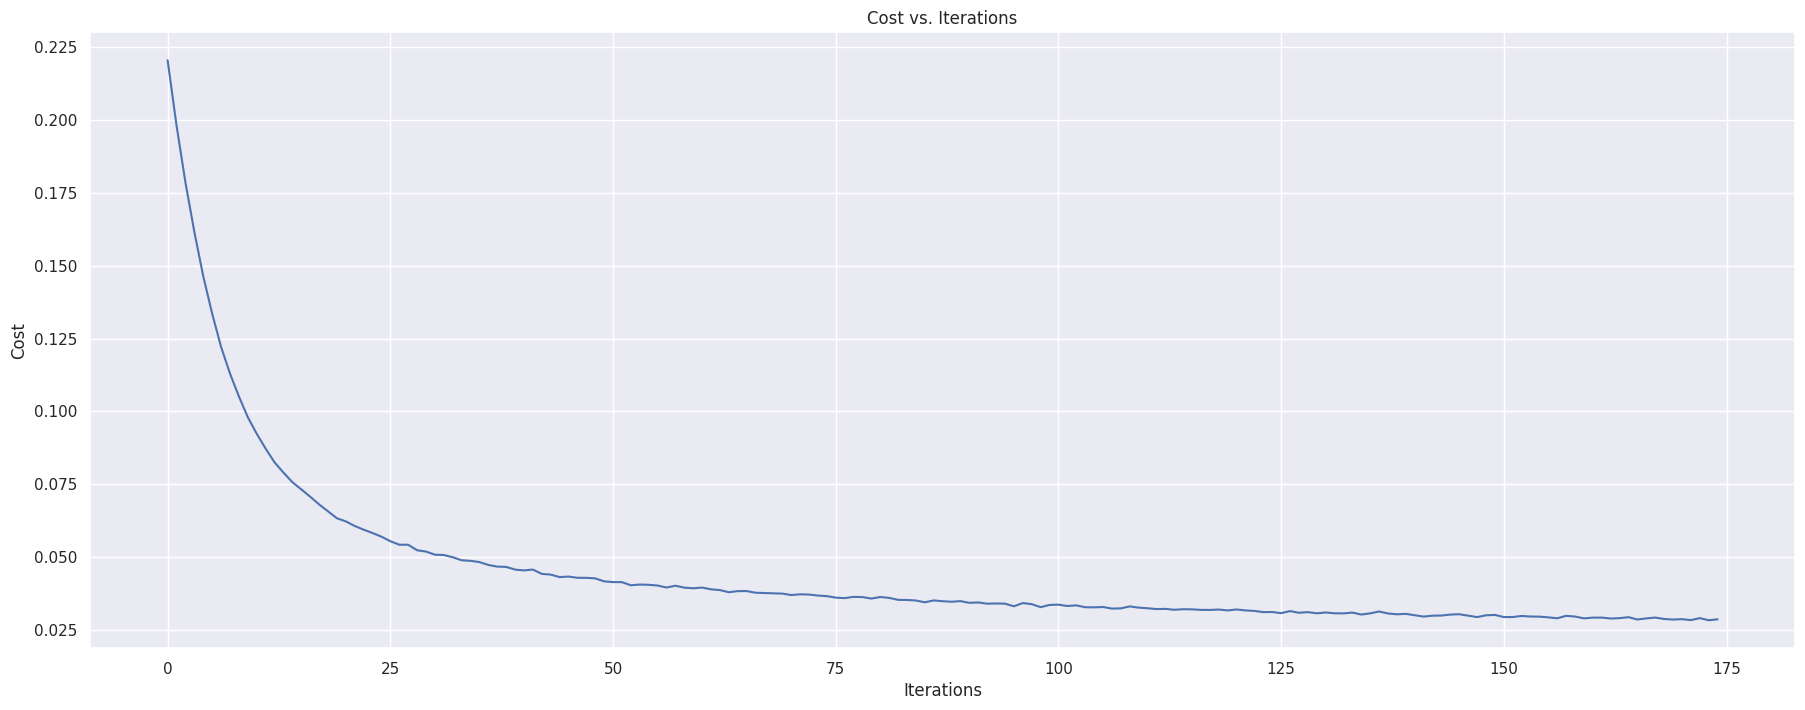

Training accuracy: 0.9199
Validation accuracy: 0.918


In [19]:
# Perform gradient descent
trained_parameters, cost_history = mini_batch_gradient_descent(features, target, input_size, hidden_size, output_size, learning_rate, num_epochs, mini_batch_size, decay_rate)

# Plot cost history
plot_cost_graph(cost_history)

# Make predictions and evaluate accuracy
predictions_train = predict(features, trained_parameters)
accuracy_train = accuracy_score(predictions_train, target)
print(f"Training accuracy: {accuracy_train:.4}")

# Extract x and y components from each mini-batch in validation set
X_val_list = []
y_val_list = []
for mini_batch_X, mini_batch_Y in mini_batches_val:
    X_val_list.append(mini_batch_X)
    y_val_list.append(mini_batch_Y)

# Concatenate the extracted lists into single arrays
X_val = np.concatenate(X_val_list, axis=1)
y_val = np.concatenate(y_val_list, axis=1)

# Make predictions on the combined validation set
predictions_val = predict(X_val, trained_parameters)

# Calculate accuracy on the validation set
accuracy_val = accuracy_score(predictions_val, y_val)
print(f"Validation accuracy: {accuracy_val:.4}")

### Task 2e. Visualizing Model Performance on Validation set

Let's visualize the model performance on the validation data.

In [20]:
def get_predictions(A2):
  return np.argmax(A2, 0)

def make_predictions(X, parameters):
  A2, _ = forward_propagation(X, parameters)
  predictions = get_predictions(A2)
  return predictions

def validation_prediction(index, parameters):
  sns.set_theme(style='dark')
  current_image = X_val[:, index, None]
  prediction = make_predictions(X_val[:, index, None], parameters)
  label_index = np.argmax(y_val[:, index])  # Find index of the maximum value in the one-hot encoded label
  label = label_index  # Assign the numerical label

  print("Prediction: ", prediction)
  print("Label: ", label)

  current_image = current_image.reshape((28, 28)) * 255
  plt.gray()
  plt.imshow(current_image, interpolation='nearest')
  plt.show();

Prediction:  [6]
Label:  6


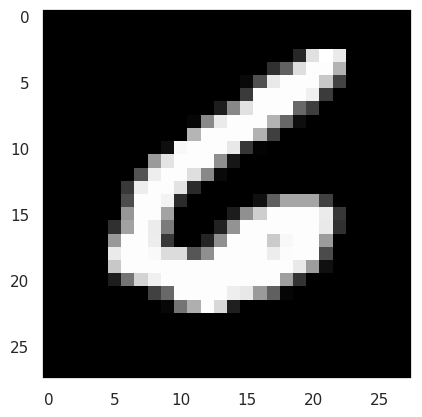

Prediction:  [4]
Label:  4


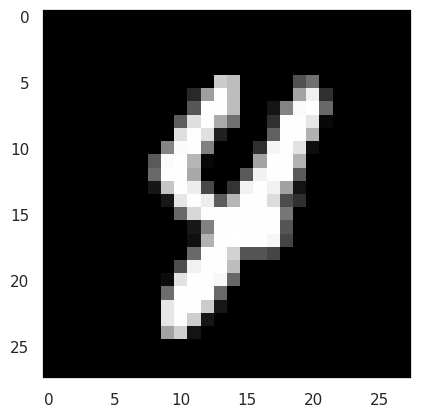

Prediction:  [0]
Label:  0


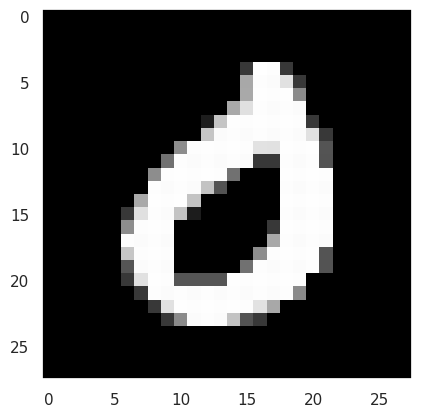

Prediction:  [5]
Label:  5


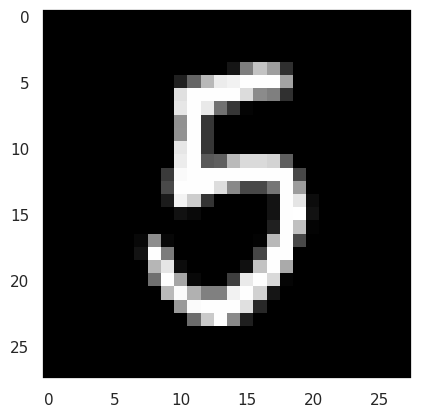

In [21]:
# Call the function
validation_prediction(0, trained_parameters)
validation_prediction(1, trained_parameters)
validation_prediction(2, trained_parameters)
validation_prediction(3, trained_parameters)

### Task 1f. Model Performance on Test data

Since the model is well-performed, let's test our model's capabilities on external test data, and compute its accuracy metrics

In [22]:
# Load and Read the Test data
test_data = pd.read_csv('/content/sample_data/mnist_test.csv')
test_data = test_data.rename(columns={'7':'label'})

# Display a few couple of rows
test_data.head()

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Convert the Test data into NumPy array, and display it
test_data = np.array(test_data)
test_data = test_data.T

test_data[:5]

array([[2, 1, 0, ..., 4, 5, 6],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
# Extract the ground truth from the data
y_test = test_data[0]

# One-Hot Encode the `y_test`
number_classes = len(np.unique(test_data[0]))
y_test = np.eye(number_classes)[y_test]
y_test = y_test.T

In [25]:
# Scale the x data by dividing it by the Maximum Pixel Factor
x_test = test_data[1:]
x_test = x_test / 255.0

In [26]:
# Display the shape of the sets
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_test: (784, 9999)
Shape of y_test: (10, 9999)


### Task 2f. Visualizing Model Performance on Test set

In [27]:
def get_predictions(A2):
  return np.argmax(A2, 0)

def make_predictions(X, parameters):
  A2, _ = forward_propagation(X, parameters)
  predictions = get_predictions(A2)
  return predictions

def test_prediction(index, parameters):
  sns.set_theme(style='dark')
  current_image = x_test[:, index, None]
  prediction = make_predictions(x_test[:, index, None], parameters)
  label_index = np.argmax(y_test[:, index])  # Find index of the maximum value in the one-hot encoded label
  label = label_index  # Assign the numerical label

  print("Prediction: ", prediction)
  print("Label: ", label)

  current_image = current_image.reshape((28, 28)) * 255
  plt.gray()
  plt.imshow(current_image, interpolation='nearest')
  plt.show();

Prediction:  [9]
Label:  9


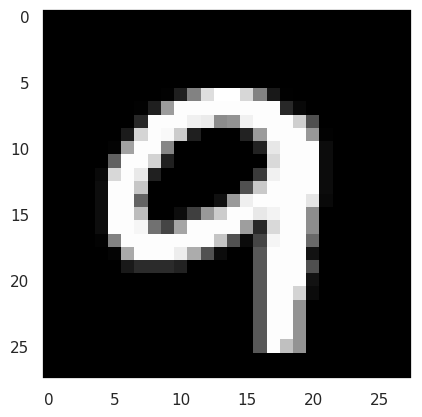

Prediction:  [7]
Label:  7


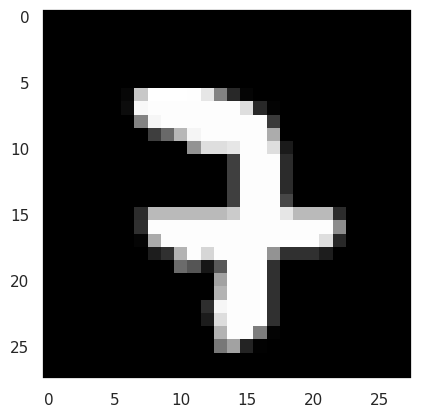

Prediction:  [3]
Label:  3


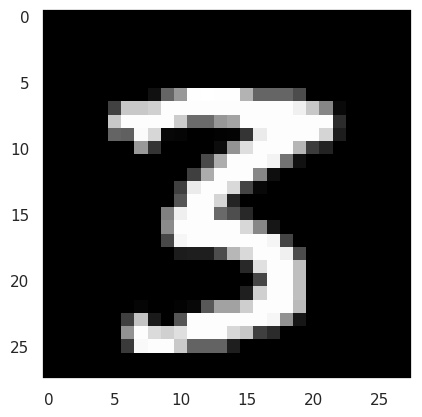

Prediction:  [8]
Label:  8


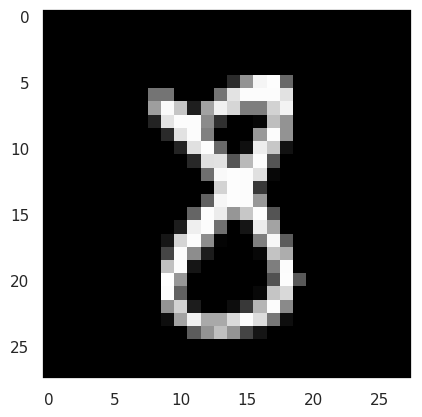

In [28]:
# Call the function
test_prediction(500, trained_parameters)
test_prediction(300, trained_parameters)
test_prediction(990, trained_parameters)
test_prediction(400, trained_parameters)

### Task 3f. Calculating Accuracy score for Model Performance on Test data

In [29]:
# Accuracy score on Test data
def predict(x_test, trained_parameters):
  a2, _ = forward_propagation(x_test, trained_parameters)
  return np.argmax(a2, axis=0)

def accuracy_score(predictions, target):
  return np.mean(predictions == np.argmax(target, axis=0))

predictions = predict(x_test, trained_parameters)
print(f"Accuracy on Test set: {accuracy_score(predictions, y_test):.4}")

Accuracy on Test set: 0.9147


### Task 4f. Visualizing Wrong Predictions

Let's see the number of incorrect predictions made by our model, and visualize them.

In [30]:
# Number of wrong predictions
len(y_test != predictions)

10

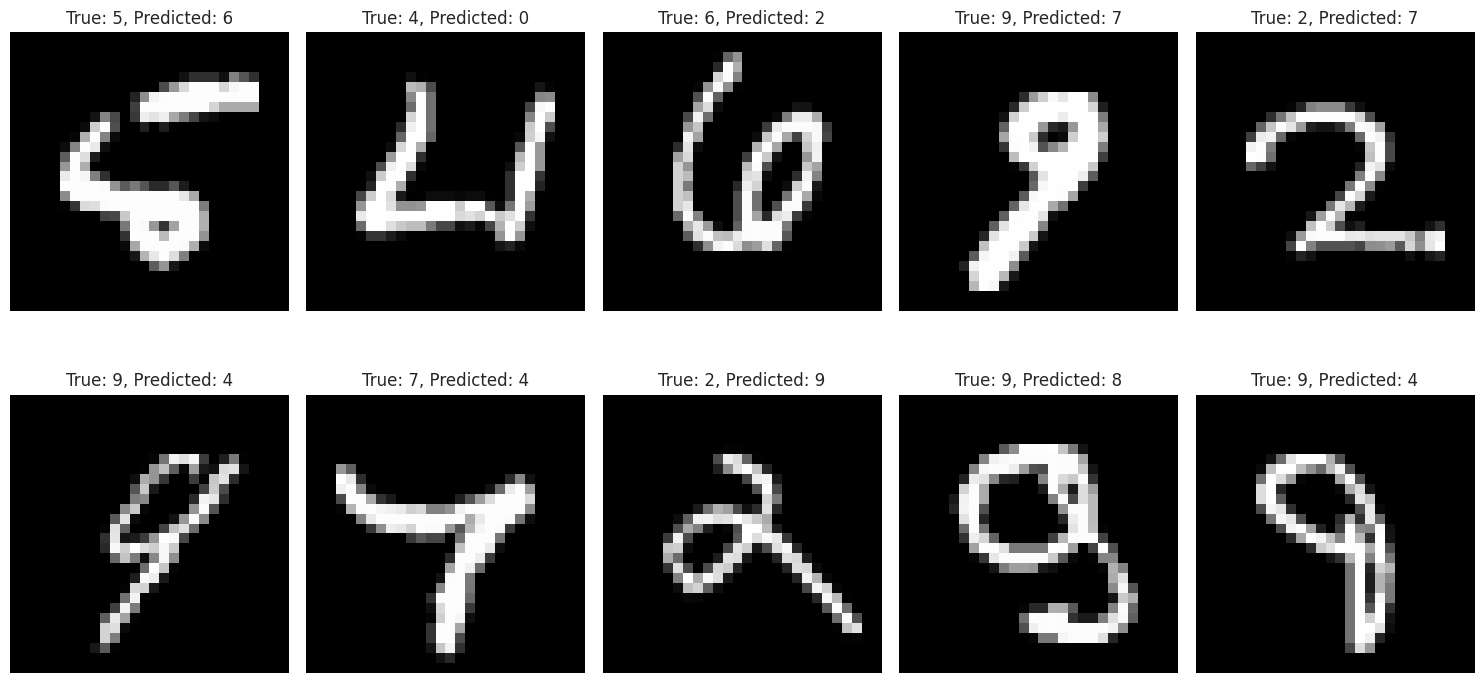

In [31]:
# Identify indices of incorrect predictions
incorrect_indices = np.where(predictions != np.argmax(y_test, axis=0))[0]

# Select first 10 incorrect indices (assuming there are at least 10 incorrect predictions)
incorrect_indices = incorrect_indices[:10]

# Plot the incorrect images alongside their correct labels
plt.figure(figsize=(15, 8))
for i, idx in enumerate(incorrect_indices):
    # Get the incorrectly predicted image and its true label
    incorrect_image = x_test[:, idx].reshape((28, 28)) * 255
    true_label = np.argmax(y_test[:, idx])

    # Make prediction for the image
    predicted_label = predictions[idx]

    # Plot the incorrect image with its predicted and true labels
    plt.subplot(2, 5, i + 1)
    plt.imshow(incorrect_image, cmap='gray')
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show();

### Conclusion

##### **Performance Analysis**

1. Training Accuracy:
> The training accuracy of 91.99% indicates that the model performs well on the training data. This suggests that the model has learned to fit the training data reasonably well.

2. Validation Accuracy:
> The validation accuracy of 91.80% is very close to the training accuracy. This suggests that the model's performance is consistent and not overfitting specifically to the training data.

3. Test Set Accuracy:
> The accuracy on the test set, which is 91.47%, is slightly lower than the training and validation accuracies. This is expected as the test set represents unseen data, and a small drop in accuracy is typical due to slight differences between training and test distributions.

It has been observed that some of the predictions made by the model were incorrect and illogical. For instance, in one of the examples, the model predicted the number 7 instead of an obvious 2.

However, it is worth noting that half of the incorrect predictions were true over the human baseline. For example, the first image's true label was 5, but the model predicted it as a 6, which is also what a human might have seen. Similarly, the second and third images were predicted as 4 and 9, respectively, while their ground truth was 7 and 2. These predictions were close to what a human might have seen as well.

Nevertheless, this indicates that the model can still improve further. Despite these inconsistencies, the overall performance of the model on the entire dataset was almost perfect.